In [28]:
from IPython import get_ipython
from IPython.display import display

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch.utils.data import Dataset
from google.colab import files

from PIL import Image


files.upload()

# Kaggle 데이터 다운로드
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 다운로드 및 압축 해제
!kaggle competitions download -c aptos2019-blindness-detection -p ./data
!unzip -qo ./data/aptos2019-blindness-detection.zip -d ./data/aptos2019

Saving kaggle.json to kaggle (1).json
aptos2019-blindness-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
class APTOSDataset(Dataset):
        def __init__(self, dataframe, img_dir, transform=None):
            self.dataframe = dataframe
            self.img_dir = img_dir
            self.transform = transform

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]
            img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
            label = int(row['diagnosis'])
            if not os.path.exists(img_path):
              raise FileNotFoundError(f"이미지 파일이 존재하지 않습니다: {img_path}")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label

In [30]:
def load_and_preprocess_data(data_path):
    train_csv = os.path.join(data_path, "train.csv")
    train_images_dir = os.path.join(data_path, "train_images")

    if not os.path.exists(train_csv):
        raise FileNotFoundError(f"The file {train_csv} does not exist. Please ensure the dataset was downloaded and extracted correctly.")
    # 데이터 로드
    df = pd.read_csv(train_csv)
    df['diagnosis'] = df['diagnosis'].astype(str)  # 레이블을 문자열로 변환

    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['diagnosis'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'], random_state=42)

    return train_df, val_df, test_df, train_images_dir

data_path = "./data/aptos2019"
train_df, val_df, test_df, train_images_dir = load_and_preprocess_data(data_path)

In [31]:
!pip install torchinfo
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [32]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [33]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [34]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [35]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [36]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [37]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [38]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [39]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [40]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [41]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [42]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=37):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [43]:
ResNet50 = timm.create_model('resnet50', pretrained=True)

In [44]:
for param in ResNet50.parameters():
    param.requires_grad = False

ResNet50.fc = nn.Identity()

In [45]:
class LauncherModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = ResNet50
        self.upsample1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(8, 3, kernel_size=4, stride=4, padding=0)

        self.levit = LevitDistilled()

    def forward(self, x):
        x = self.resnet(x)  # (32, 2048)
        x = x.view(x.size(0), 32, 8, 8)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.levit(x)
        return x

In [46]:
model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 0.001
num_epochs = 50

LauncherModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [47]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                       Output Shape              Param #
LauncherModel                                                [32, 37]                  --
├─ResNet: 1-1                                                [32, 2048]                --
│    └─Conv2d: 2-1                                           [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                                      [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                                             [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                                        [32, 64, 56, 56]          --
│    └─Sequential: 2-5                                       [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                                  [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                                  [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                                  [32, 256, 56, 

In [48]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                       Output Shape              Param #
LauncherModel                                                [32, 37]                  --
├─ResNet: 1-1                                                [32, 2048]                --
│    └─conv1.weight                                                                    ├─9,408
│    └─bn1.weight                                                                      ├─64
│    └─bn1.bias                                                                        ├─64
│    └─layer1.0.conv1.weight                                                           ├─4,096
│    └─layer1.0.bn1.weight                                                             ├─64
│    └─layer1.0.bn1.bias                                                               ├─64
│    └─layer1.0.conv2.weight                                                           ├─36,864
│    └─layer1.0.bn2.weight                                             

In [49]:
data_dir = "./data/aptos2019"
train_csv = os.path.join(data_dir, "train.csv")
df = pd.read_csv(train_csv)

#클래스 균형 맞추기
# def balance_classes(df):
#     max_count = df['diagnosis'].value_counts().max()
#     balanced_df = pd.DataFrame()
#     for class_label, group in df.groupby('diagnosis'):
#         balanced_group = resample(group, replace=True, n_samples=max_count, random_state=42)
#         balanced_df = pd.concat([balanced_df, balanced_group])
#     return balanced_df

# balanced_df = balance_classes(df)


def split_dataset(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    train_df, temp_df = train_test_split(
        df,
        test_size=(1 - train_ratio),
        stratify=df['diagnosis'],
        random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(test_ratio / (val_ratio + test_ratio)),
        stratify=temp_df['diagnosis'],
        random_state=42
    )
    return train_df, val_df, test_df

train_df, val_df, test_df = split_dataset(df)

# 분할된 데이터 저장
train_df.to_csv(os.path.join(data_dir, "train_balanced.csv"), index=False)
val_df.to_csv(os.path.join(data_dir, "val_balanced.csv"), index=False)
test_df.to_csv(os.path.join(data_dir, "test_balanced.csv"), index=False)

# 클래스별 분포 출력
print("Balanced Train 세트 클래스 분포:")
print(train_df['diagnosis'].value_counts().sort_index())

print("\nBalanced Validation 세트 클래스 분포:")
print(val_df['diagnosis'].value_counts().sort_index())

print("\nBalanced Test 세트 클래스 분포:")
print(test_df['diagnosis'].value_counts().sort_index())

Balanced Train 세트 클래스 분포:
diagnosis
0    1263
1     259
2     699
3     135
4     207
Name: count, dtype: int64

Balanced Validation 세트 클래스 분포:
diagnosis
0    271
1     55
2    150
3     29
4     44
Name: count, dtype: int64

Balanced Test 세트 클래스 분포:
diagnosis
0    271
1     56
2    150
3     29
4     44
Name: count, dtype: int64


In [50]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [51]:
train_dataset = APTOSDataset(train_df, train_images_dir, transform=transform)
val_dataset = APTOSDataset(val_df, train_images_dir, transform=transform)
test_dataset = APTOSDataset(test_df, train_images_dir, transform=transform)

In [52]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 2563
Validation set size: 549
Test set size: 550


In [53]:
def show_images(dataset, num_images=5):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

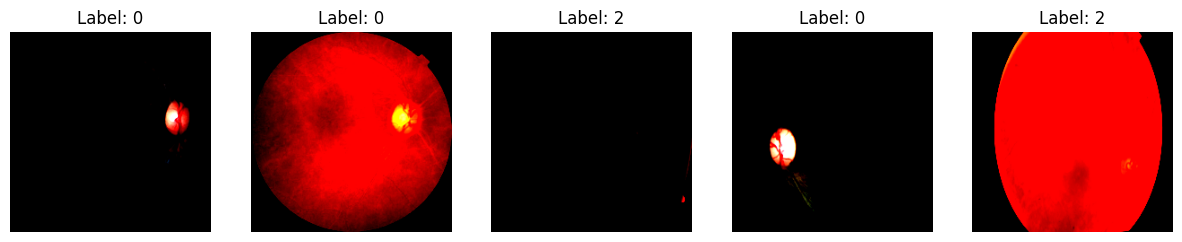

In [54]:
show_images(train_dataset, num_images=5)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [57]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [58]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_loss.append(epoch_loss)
        val_acc.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [59]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [60]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/50


Training: 100%|██████████| 81/81 [01:20<00:00,  1.01it/s]


Train Loss: 1.7169, Train Accuracy: 60.48%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 4.2478, Validation Accuracy: 5.65%

Epoch 2/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 1.1241, Train Accuracy: 67.19%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 1.3023, Validation Accuracy: 67.76%

Epoch 3/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 1.1864, Train Accuracy: 66.99%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 1.5192, Validation Accuracy: 59.38%

Epoch 4/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.9415, Train Accuracy: 68.51%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.9190, Validation Accuracy: 68.49%

Epoch 5/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Train Loss: 0.8944, Train Accuracy: 70.43%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.8286, Validation Accuracy: 69.95%

Epoch 6/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.8013, Train Accuracy: 69.37%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.8879, Validation Accuracy: 70.67%

Epoch 7/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.7846, Train Accuracy: 72.14%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7689, Validation Accuracy: 72.13%

Epoch 8/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Train Loss: 0.8074, Train Accuracy: 70.00%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.8537, Validation Accuracy: 70.67%

Epoch 9/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Train Loss: 0.7229, Train Accuracy: 72.69%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7937, Validation Accuracy: 68.12%

Epoch 10/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.7043, Train Accuracy: 73.62%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7972, Validation Accuracy: 68.49%

Epoch 11/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.7029, Train Accuracy: 73.78%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7678, Validation Accuracy: 71.77%

Epoch 12/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6681, Train Accuracy: 74.33%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7515, Validation Accuracy: 72.13%

Epoch 13/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6641, Train Accuracy: 74.56%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7599, Validation Accuracy: 72.86%

Epoch 14/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6586, Train Accuracy: 74.83%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7530, Validation Accuracy: 73.22%

Epoch 15/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.6467, Train Accuracy: 75.69%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7801, Validation Accuracy: 72.68%

Epoch 16/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6502, Train Accuracy: 75.81%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.6984, Validation Accuracy: 73.59%

Epoch 17/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.6499, Train Accuracy: 75.77%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7662, Validation Accuracy: 73.95%

Epoch 18/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6076, Train Accuracy: 76.67%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7356, Validation Accuracy: 74.32%

Epoch 19/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6085, Train Accuracy: 76.59%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7389, Validation Accuracy: 73.41%

Epoch 20/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5992, Train Accuracy: 76.82%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7169, Validation Accuracy: 74.50%

Epoch 21/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6108, Train Accuracy: 77.37%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7708, Validation Accuracy: 67.94%

Epoch 22/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.5609, Train Accuracy: 78.23%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8188, Validation Accuracy: 73.04%

Epoch 23/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5685, Train Accuracy: 78.19%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6925, Validation Accuracy: 73.77%

Epoch 24/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6413, Train Accuracy: 77.80%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7973, Validation Accuracy: 71.77%

Epoch 25/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6731, Train Accuracy: 75.61%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7564, Validation Accuracy: 73.41%

Epoch 26/50


Training: 100%|██████████| 81/81 [01:20<00:00,  1.00it/s]


Train Loss: 0.5510, Train Accuracy: 77.68%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7107, Validation Accuracy: 74.13%

Epoch 27/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5875, Train Accuracy: 77.57%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7183, Validation Accuracy: 74.68%

Epoch 28/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.5493, Train Accuracy: 79.83%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]


Validation Loss: 0.7327, Validation Accuracy: 74.13%

Epoch 29/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.6749, Train Accuracy: 75.03%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7114, Validation Accuracy: 72.13%

Epoch 30/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.5775, Train Accuracy: 78.58%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7820, Validation Accuracy: 72.31%

Epoch 31/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.6103, Train Accuracy: 76.79%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.6940, Validation Accuracy: 73.95%

Epoch 32/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.5889, Train Accuracy: 77.49%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.6840, Validation Accuracy: 74.86%

Epoch 33/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.5388, Train Accuracy: 80.06%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7291, Validation Accuracy: 73.95%

Epoch 34/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.02s/it]


Train Loss: 0.5791, Train Accuracy: 80.41%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7725, Validation Accuracy: 74.32%

Epoch 35/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.6450, Train Accuracy: 74.60%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7440, Validation Accuracy: 72.50%

Epoch 36/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Train Loss: 0.5463, Train Accuracy: 79.24%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7500, Validation Accuracy: 73.77%

Epoch 37/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.5145, Train Accuracy: 80.92%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.8538, Validation Accuracy: 67.40%

Epoch 38/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5346, Train Accuracy: 79.56%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


Validation Loss: 0.6873, Validation Accuracy: 75.77%

Epoch 39/50


Training: 100%|██████████| 81/81 [01:23<00:00,  1.03s/it]


Train Loss: 0.5175, Train Accuracy: 80.02%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7381, Validation Accuracy: 74.13%

Epoch 40/50


Training: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]


Train Loss: 0.5130, Train Accuracy: 80.69%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7593, Validation Accuracy: 73.59%

Epoch 41/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.4884, Train Accuracy: 81.97%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7279, Validation Accuracy: 76.50%

Epoch 42/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.01s/it]


Train Loss: 0.4775, Train Accuracy: 81.78%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8177, Validation Accuracy: 68.31%

Epoch 43/50


Training: 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


Train Loss: 0.5424, Train Accuracy: 78.77%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Validation Loss: 0.7183, Validation Accuracy: 76.14%

Epoch 44/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.4800, Train Accuracy: 81.43%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7068, Validation Accuracy: 77.05%

Epoch 45/50


Training: 100%|██████████| 81/81 [01:24<00:00,  1.04s/it]


Train Loss: 0.4836, Train Accuracy: 82.21%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7523, Validation Accuracy: 76.87%

Epoch 46/50


Training: 100%|██████████| 81/81 [01:25<00:00,  1.06s/it]


Train Loss: 0.4910, Train Accuracy: 80.84%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8947, Validation Accuracy: 72.86%

Epoch 47/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.00s/it]


Train Loss: 0.4725, Train Accuracy: 81.86%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8193, Validation Accuracy: 71.04%

Epoch 48/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.4479, Train Accuracy: 82.95%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.8051, Validation Accuracy: 73.59%

Epoch 49/50


Training: 100%|██████████| 81/81 [01:20<00:00,  1.00it/s]


Train Loss: 0.4910, Train Accuracy: 82.64%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


Validation Loss: 0.7967, Validation Accuracy: 74.86%

Epoch 50/50


Training: 100%|██████████| 81/81 [01:21<00:00,  1.01s/it]


Train Loss: 0.4695, Train Accuracy: 81.74%


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]

Validation Loss: 0.6896, Validation Accuracy: 76.50%


In [61]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 18/18 [00:20<00:00,  1.11s/it]

Test Loss: 0.7717, Test Accuracy: 74.73%


In [62]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 18
Average Time: 16.04 ms
Standard Deviation: 1.51 ms
Maximum Time: 21.14 ms
Minimum Time: 14.00 ms


In [63]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::convolution         1.67%     459.435us        40.04%      11.037ms     178.022us       0.000us         0.00%       7.225ms     116.538us            62  
                                     aten::_convolution         9.22%       2.542ms        38.37%      10.578ms     170.612us       0.000us         0.00%       7.225ms     116.538us            62  
         

In [64]:
save_path = "L_HoViT_APTOS2019.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to L_HoViT_APTOS2019.pth


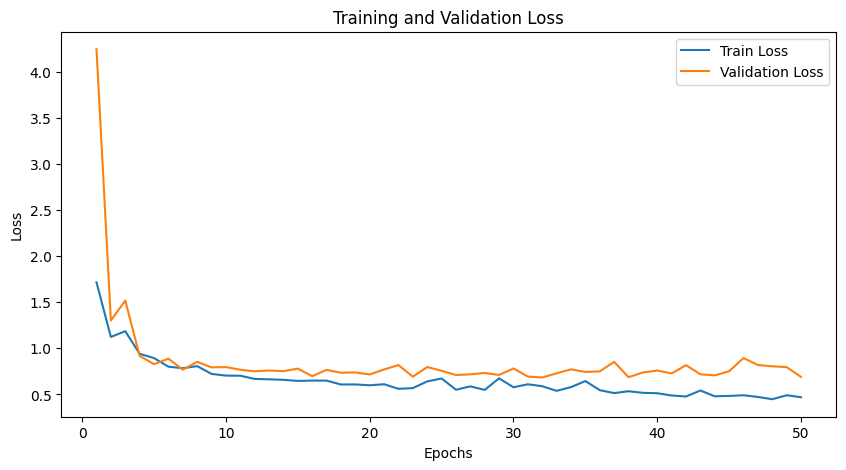

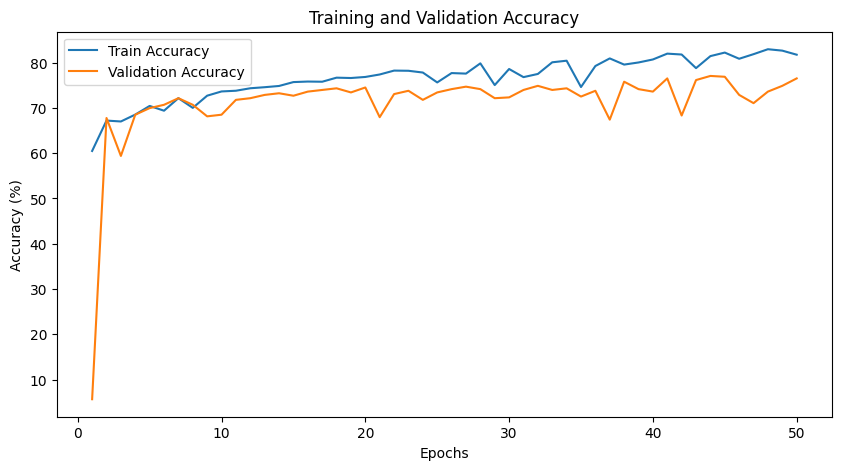

In [65]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss)+1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()